## Utilizing Transfer Learning on ResNet50 to build a cars classifier using Stanford Cars Dataset 

For the sake of simplicity and ease, the following notebook is run on kaggle virtual environment. The dataset used is Stanford cars dataset, which is also provided by kaggle in their list. 
URL: https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder

Information about dataset:
The dataset had 8144 training images and 8041 testing images, with 196 classes present in the whole dataset. On average, each class has around 40 images in both training and testing set.

According to https://paperswithcode.com/sota/fine-grained-image-classification-on-stanford , ResNet50 architectures give an accuracy of maximum 92.7% when trained on stanford cars dataset.

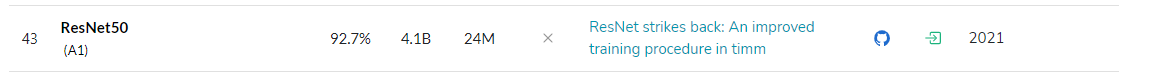

Goals of this project: 
1. to build model that is able to achieve atleast 90% accuracy on test dataset
2. to test the effects of image transformations on the model and how much it increases the accuracy.

To achieve the above goals, three sections will be presented in this notebook.  </br>
In the first section we build a base model without changing the images other than resizing them. </br>
In the second section we build the same model but we apply <b>normalization</b> to images. </br>
and in third section we build the same model but with both <b>image transformations</b> and <b>normalization</b> applied to the base images. </br>
Finally, the accuracies are measured and judged.

<b>NOTE:</b> most of the code in the notebook has been used from the official pytorch documention on how to perform transfer learning.

After tuning, the following hyperparameters have shown to give optimal results.
For this project, the hyperparameters are kept constant so that we can compare the final results.

learning rate: 0.01</br>
batch size: 32</br>
epochs: 15</br> 

optimizer: SGD

for transfer learning , we are using ResNet-50 and the last layer is replaced with an untrained fully connected layer of size 196

The images are resized to 400 x 400 and the normalization is done with mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). </br>
While 224 x 224 is normally used for ResNet 50 architecture, on performing a few tests that size is shown to not be enough for the model to learn well. Since pytorch allows its users to use images higher than 224 x 224, I decided to use that feature instead.

When using image transformations, the following transformations are used </br>
1. transforms.RandomHorizontalFlip() </br>
2. transforms.RandomAffine(0, shear=10, scale=(0.8,1.2))</br>
3. transforms.RandomRotation(15)</br>

In [9]:
import matplotlib.pyplot as plt
import time
import os
import PIL.Image as Image
from IPython.display import display
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

### Training and evaluation functions

In [10]:
# Function to train model
def train_model(model, criterion, optimizer , n_epochs):
    accr_list = []
    test_accr_list = []
    
    # start model in train mode
    model.train()
    
    # iterate through number of epochs
    for epoch in range(n_epochs):
        start_time = time.time()
        
        # to calculate loss and number of corrects
        running_loss = 0.0
        running_correct = 0.0
        
        # iterate over train data
        for i, data in enumerate(trainloader, 0):

            # get the inputs
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            # forward propagation
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            # backward propagation
            loss.backward()
            
            # optimize
            optimizer.step()
            
            # find loss and number of corrects
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-start_time
        
        # find loss
        epoch_loss = running_loss/len(trainloader)
        
        # find accuracy
        epoch_acc = 100/32*running_correct/len(trainloader)
        
        print("Epoch:", epoch+1," duration:", epoch_duration, " loss:", epoch_loss, " acc:", epoch_acc)
        
        accr_list.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accr_list.append(test_acc)
        
        # change back to train mode
        model.train()
    print('Finished Training')
    return model, accr_list, test_accr_list

In [11]:
# function to evaluate test data after each iteration
def eval_model(model):
    
    # iterators to count total and correct from the test images
    correct = 0.0
    total = 0.0
    
    with torch.no_grad():
        
        # iterate over test data
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    # calculate accuracy
    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

### Section 1: Building a model without normalization and image transformations

In [12]:
directory = "../input/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.ToTensor()])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(root=directory+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=directory+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


In [13]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [14]:
model_ft, training_accs, test_accs = train_model(model_ft, criterion, optimizer, n_epochs=15)

### Section 2: Building a model with just image Normalization

In [15]:
directory = "../input/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root=directory+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=directory+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


In [16]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [17]:
model_ft, training_accs, test_accs = train_model(model_ft, criterion, optimizer, n_epochs=15)

### Section 3: Building a model with both normalization and image transformations

In [21]:
directory = "../input/car_data/car_data/"

train_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
test_tfms = transforms.Compose([transforms.Resize((400, 400)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


dataset = torchvision.datasets.ImageFolder(root=directory+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=directory+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


In [22]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

In [23]:
model_ft, training_accs, test_accs = train_model(model_ft, criterion, optimizer, n_epochs=17)

### Conclusion

Models in both section 1 and section 2 show similar results, but model 3 has shown to give slightly different results. The value of train loss is decreasing slower than previous models per epoch. Furthermore, the accuracy on test data is slightly lower than before, however this slight decrease is not a massive problem as training for a few more epochs should let the model learn enough to achieve the same level of accuracy. 

The learning is slow but steady when we use image transformations. 

From this, we can infer that the random image transformations are giving the model a regularization effect.